<a href="https://colab.research.google.com/github/solcanalla/fiumark/blob/main/knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo: KNN #


##Inicialización##

In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

In [16]:
!git clone https://github.com/solcanalla/fiumark.git
%cd fiumark
!git pull origin main
import preprocessing as pp

Cloning into 'fiumark'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 135 (delta 75), reused 46 (delta 19), pack-reused 0
Receiving objects: 100% (135/135), 37.76 KiB | 226.00 KiB/s, done.
Resolving deltas: 100% (75/75), done.
/content/fiumark/fiumark
From https://github.com/solcanalla/fiumark
 * branch            main       -> FETCH_HEAD
Already up to date.


In [17]:
from sklearn.metrics import roc_curve, auc

def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
    )
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

##Pre procesamiento##

Para KNN es importante escalar los datos. 

In [18]:
pd.options.display.max_columns = None

df = pp.get_dataset()
df = pp.knn_preprocessing(df)
X_train, X_test, y_train, y_test = pp.get_train_test_data(df)


##Entrenamiento##

In [19]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_neighbors': np.arange(1, 100),
    'weights': ['uniform', 'distance'],
    'metric': ['cosine','minkowski'],
    'algorithm':['ball_tree','kd_tree','brute','auto'],
    'leaf_size': [30,40,50]
}

clf = KNeighborsClassifier()

rgscv = RandomizedSearchCV(
    clf, params, n_iter=200, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

In [20]:
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.841589880414191
Best params {'weights': 'distance', 'n_neighbors': 27, 'metric': 'minkowski', 'leaf_size': 50, 'algorithm': 'ball_tree'}


##Evaluación del modelo##

In [21]:
y_pred = rgscv.predict(X_test)

###Precision recall y F1-score###

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86        95
         1.0       0.85      0.68      0.76        66

    accuracy                           0.82       161
   macro avg       0.83      0.80      0.81       161
weighted avg       0.82      0.82      0.82       161



###Accuracy###

In [23]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8198757763975155

###Auc-Roc###

In [24]:
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test, y_pred)
auc_roc

0.7988038277511961

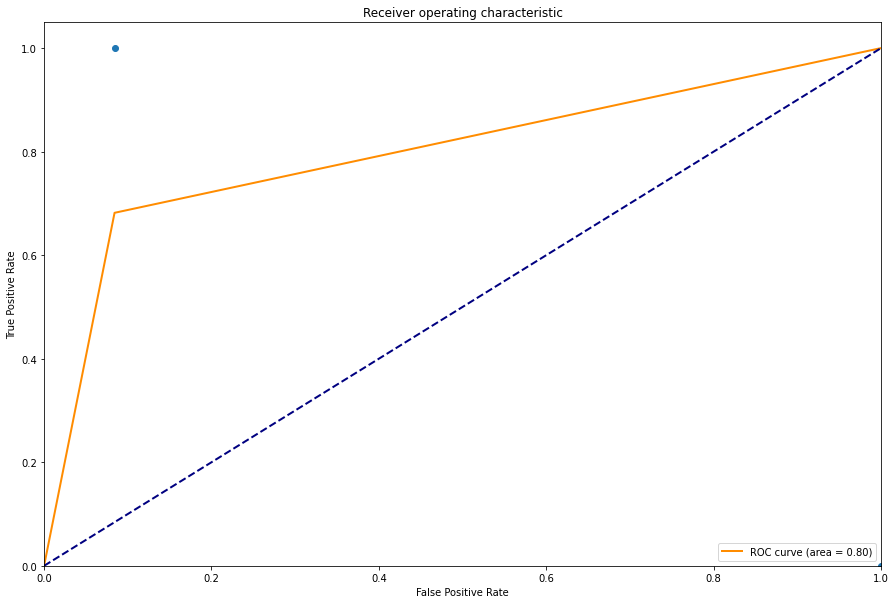

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plot_roc(fpr, tpr, thresholds)


###Matriz de confusión###

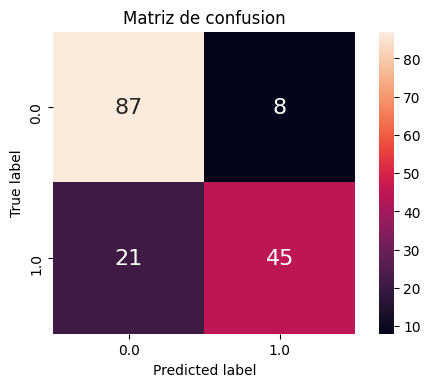

In [26]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, y_pred)

##Predicción##

In [27]:
X_holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')
X = pp.knn_preprocessing(X_holdout)
prediction = pd.DataFrame(rgscv.predict(X),columns=['volveria'],dtype=int)
pred_formatted = pd.concat([X_holdout.id_usuario,prediction],axis=1)
pred_formatted.to_csv('knn.csv')
pred_formatted

,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0
...,...,...
85,354,0
86,82,0
87,172,0
88,8,0
